In [316]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Proyecto

La idea es predecir el ganador de la Copa América 2024 usando machine learning y los datasets: [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) and [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking)

Usé la misma lógica que se usó en el [Ganador de la Copa Mundial de Fútbol 2022
](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2022-winner), que modela el problema como uno de clasificación binaria. Utilicé esto para facilitar el análisis de los resultados del modelo, de modo que el modelo prediga entre la victoria del equipo local y el empate/victoria del equipo visitante. Luego, para eliminar la ventaja del equipo visitante, se predicen los resultados cambiando los equipos de visitante y local (porque no hay ventaja de local en la Copa América) y se utiliza como probabilidades la media de las dos predicciones.

# Data Preparation

Aquí, se preparan los datos para aplicar métodos de feature engineering que crearán la base de datos para aplicar algoritmos de ML.

Primero analizamos los datos correspondientes a los resultados de enfrentamientos entre selecciones:

In [317]:
df =  pd.read_csv("results.csv")

In [318]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [319]:
df["date"] = pd.to_datetime(df["date"])

In [320]:
df.isnull().sum()

date           0
home_team     25
away_team     25
home_score    92
away_score    92
tournament     0
city           0
country        0
neutral        0
dtype: int64

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47379 entries, 0 to 47378
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        47379 non-null  datetime64[ns]
 1   home_team   47354 non-null  object        
 2   away_team   47354 non-null  object        
 3   home_score  47287 non-null  float64       
 4   away_score  47287 non-null  float64       
 5   tournament  47379 non-null  object        
 6   city        47379 non-null  object        
 7   country     47379 non-null  object        
 8   neutral     47379 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), object(5)
memory usage: 2.9+ MB


In [322]:
df.dropna(inplace=True)

In [323]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
47280,2024-06-14,Germany,Scotland,5.0,1.0,UEFA Euro,Munich,Germany,False
47284,2024-06-15,Spain,Croatia,3.0,0.0,UEFA Euro,Berlin,Germany,True
47285,2024-06-15,Italy,Albania,2.0,1.0,UEFA Euro,Dortmund,Germany,True
47283,2024-06-15,Hungary,Switzerland,1.0,3.0,UEFA Euro,Cologne,Germany,True
47288,2024-06-15,Vanuatu,Solomon Islands,1.0,0.0,Oceania Nations Cup,Port Vila,Vanuatu,False


Ahora analizamos los datos que corresponden a los rankings de los equipos:

In [324]:
rank = pd.read_csv("fifa_ranking-2024-04-04.csv")

Modificamos los nombres de algunos equipos para que coincidan con los del dataset de resultados:

In [325]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

In [326]:
rank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67261 entries, 0 to 67260
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             67253 non-null  float64
 1   country_full     67261 non-null  object 
 2   country_abrv     67261 non-null  object 
 3   total_points     67261 non-null  float64
 4   previous_points  67261 non-null  float64
 5   rank_change      67261 non-null  int64  
 6   confederation    67261 non-null  object 
 7   rank_date        67261 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 4.1+ MB


In [327]:
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,83.0,Guatemala,GUA,15.0,0.0,83,CONCACAF,1992-12-31
1,32.0,Zambia,ZAM,38.0,0.0,32,CAF,1992-12-31
2,33.0,Portugal,POR,38.0,0.0,33,UEFA,1992-12-31
3,34.0,Austria,AUT,38.0,0.0,34,UEFA,1992-12-31
4,35.0,Colombia,COL,36.0,0.0,35,CONMEBOL,1992-12-31


Tomamos los datos del dataset de resultados correspondientes a fechas mayores a la mínima reportada en rankings:

In [328]:
df = df[(df["date"] >= "1992-12-31")].reset_index(drop=True)

In [329]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1993-01-01,Ghana,Mali,1.0,1.0,Friendly,Libreville,Gabon,True
1,1993-01-02,Gabon,Burkina Faso,1.0,1.0,Friendly,Libreville,Gabon,False
2,1993-01-02,Kuwait,Lebanon,2.0,0.0,Friendly,Kuwait City,Kuwait,False
3,1993-01-03,Burkina Faso,Mali,1.0,0.0,Friendly,Libreville,Gabon,True
4,1993-01-03,Gabon,Ghana,2.0,3.0,Friendly,Libreville,Gabon,False


In [330]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])

In [331]:
rank.tail()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
67256,140.0,Burundi,BDI,1081.63,1085.83,0,CAF,2024-04-04
67257,139.0,Kuwait,KUW,1085.46,1094.05,2,AFC,2024-04-04
67258,138.0,Malaysia,MAS,1094.54,1110.17,6,AFC,2024-04-04
67259,162.0,Tahiti,TAH,999.48,999.48,-1,OFC,2024-04-04
67260,5.0,Brazil,BRA,1788.65,1784.09,0,CONMEBOL,2024-04-04


In [199]:
# American_Cup_participants = ['Argentina', 'Peru', 'Chile', 'Canada', 'Mexico',
#                              'Ecuador', 'Venezuela', 'Jamaica', 'United States',
#                               'Uruguay', 'Panama', 'Bolivia', 'Brazil',
#                                'Paraguay', 'Colombia', 'Costa Rica']

In [200]:
# rank[rank['country_full'].isin(American_Cup_participants)].tail(16)

In [332]:
last_date_df = df['date'].unique()[-1]
last_date_rank = rank['rank_date'].unique()[-1]
print(last_date_df, last_date_rank)

2024-06-15 00:00:00 2024-04-04 00:00:00


Se observa que la última fecha registrada en el dataset de rankins es menor que la fecha registrada en el dataset de resultados. Entonces, cambiamos la última fecha de rankings por la de resultados para que al unir los datasets aparezcan los últimos encuentros entre selecciones:

In [333]:
rank.loc[rank['rank_date'] == last_date_rank, 'rank_date'] = last_date_df

In [203]:
# rank[rank['country_full'].isin(American_Cup_participants)].tail(16)

Se quiere crear un solo dataset conteniendo toda la información, pero las fechas no coinciden. Una solución es tomar 'rank_date' como índice, agrupar por país ('country_full'), resamplear a frecuencia diaria tomando la primera fila de cada grupo, llenar los valores NA propagando el último dato válido, y por último reseteando el índice.   

In [334]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().ffill().reset_index()

In [335]:
rank.tail()

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
2327067,2024-06-11,124.0,Zimbabwe,ZIM,1144.56,1144.56,0.0,CAF
2327068,2024-06-12,124.0,Zimbabwe,ZIM,1144.56,1144.56,0.0,CAF
2327069,2024-06-13,124.0,Zimbabwe,ZIM,1144.56,1144.56,0.0,CAF
2327070,2024-06-14,124.0,Zimbabwe,ZIM,1144.56,1144.56,0.0,CAF
2327071,2024-06-15,122.0,Zimbabwe,ZIM,1143.66,1144.56,-2.0,CAF


Ahora se puede crear un solo dataset:

In [336]:
df_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_ranked = df_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [337]:
df_ranked.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
24095,2024-06-14,El Salvador,Peru,0.0,1.0,Friendly,Philadelphia,United States,True,1306.14,1306.14,81.0,3.0,1512.68,1512.68,33.0,-2.0
24096,2024-06-15,Hungary,Switzerland,1.0,3.0,UEFA Euro,Cologne,Germany,True,1532.20,1525.13,26.0,-1.0,1616.41,1613.44,19.0,0.0
24097,2024-06-15,Spain,Croatia,3.0,0.0,UEFA Euro,Berlin,Germany,True,1727.50,1732.64,8.0,0.0,1721.07,1717.57,10.0,0.0
24098,2024-06-15,Italy,Albania,2.0,1.0,UEFA Euro,Dortmund,Germany,True,1724.60,1718.82,9.0,0.0,1375.10,1382.69,66.0,2.0
24099,2024-06-15,Vanuatu,Solomon Islands,1.0,0.0,Oceania Nations Cup,Port Vila,Vanuatu,False,972.14,980.33,172.0,2.0,1111.02,1113.57,132.0,1.0


In [338]:
df_ranked.to_csv('df_ranked.csv', index=False)

In [339]:
df_ranked =  pd.read_csv("df_ranked.csv")

Podemos usar los datos correspondientes a la anterior Copa América (2021) en adelante, para evitar que la taryectoria historica de los paises influya demasiado. 

In [340]:
df_ranked['tournament'].unique()

array(['Friendly', 'FIFA World Cup qualification',
       'African Cup of Nations qualification', 'Nehru Cup',
       'Merdeka Tournament', "King's Cup", 'UNCAF Cup',
       'Four Nations Tournament', 'CONMEBOL–UEFA Cup of Champions',
       'Copa Paz del Chaco', 'Kirin Cup',
       'CFU Caribbean Cup qualification', 'CFU Caribbean Cup', 'USA Cup',
       'Southeast Asian Games', 'Korea Cup', 'Copa América', 'Baltic Cup',
       'Gold Cup', 'Indian Ocean Island Games', 'Amílcar Cabral Cup',
       'South Pacific Mini Games', 'South Asian Games',
       'United Arab Emirates Friendship Tournament',
       'Malta International Tournament', 'Lunar New Year Cup',
       'Joe Robbie Cup', 'African Cup of Nations',
       'UEFA Euro qualification', 'Miami Cup', 'FIFA World Cup',
       'Oceania Nations Cup qualification', 'Asian Games', 'Gulf Cup',
       'CECAFA Cup', 'Simba Tournament', 'Confederations Cup',
       'Dynasty Cup', 'SAFF Cup', 'South Pacific Games',
       'Oceania Nations C

In [341]:
df_ranked[df_ranked['tournament'] == 'Copa América'].tail(30)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
20117,2019-07-06,Argentina,Chile,2.0,1.0,Copa América,São Paulo,Brazil,True,1582.00,1580.00,11.0,0.0,1561.00,1559.00,16.0,1.0
20119,2019-07-07,Brazil,Peru,3.0,1.0,Copa América,Rio de Janeiro,Brazil,False,1681.00,1676.00,3.0,0.0,1516.00,1516.00,21.0,0.0
21309,2021-06-13,Brazil,Venezuela,3.0,0.0,Copa América,Brasília,Brazil,False,1742.65,1742.65,3.0,0.0,1500.71,1500.71,30.0,0.0
21310,2021-06-13,Colombia,Ecuador,1.0,0.0,Copa América,Cuiabá,Brazil,True,1600.66,1600.66,15.0,0.0,1413.01,1413.01,53.0,0.0
21314,2021-06-14,Argentina,Chile,1.0,1.0,Copa América,Rio de Janeiro,Brazil,True,1641.95,1641.95,8.0,0.0,1569.52,1569.52,19.0,0.0
21315,2021-06-14,Paraguay,Bolivia,3.0,1.0,Copa América,Goiânia,Brazil,True,1476.02,1476.02,35.0,0.0,1300.11,1300.11,81.0,0.0
21340,2021-06-17,Colombia,Venezuela,0.0,0.0,Copa América,Goiânia,Brazil,True,1600.66,1600.66,15.0,0.0,1500.71,1500.71,30.0,0.0
21341,2021-06-17,Brazil,Peru,4.0,0.0,Copa América,Rio de Janeiro,Brazil,False,1742.65,1742.65,3.0,0.0,1511.88,1511.88,27.0,0.0
21345,2021-06-18,Chile,Bolivia,1.0,0.0,Copa América,Cuiabá,Brazil,True,1569.52,1569.52,19.0,0.0,1300.11,1300.11,81.0,0.0
21346,2021-06-18,Argentina,Uruguay,1.0,0.0,Copa América,Brasília,Brazil,True,1641.95,1641.95,8.0,0.0,1639.08,1639.08,9.0,0.0


In [342]:
df_ranked = df_ranked[df_ranked["date"] >= "2021-06-13"]

In [344]:
df_ranked.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
24095,2024-06-14,El Salvador,Peru,0.0,1.0,Friendly,Philadelphia,United States,True,1306.14,1306.14,81.0,3.0,1512.68,1512.68,33.0,-2.0
24096,2024-06-15,Hungary,Switzerland,1.0,3.0,UEFA Euro,Cologne,Germany,True,1532.20,1525.13,26.0,-1.0,1616.41,1613.44,19.0,0.0
24097,2024-06-15,Spain,Croatia,3.0,0.0,UEFA Euro,Berlin,Germany,True,1727.50,1732.64,8.0,0.0,1721.07,1717.57,10.0,0.0
24098,2024-06-15,Italy,Albania,2.0,1.0,UEFA Euro,Dortmund,Germany,True,1724.60,1718.82,9.0,0.0,1375.10,1382.69,66.0,2.0
24099,2024-06-15,Vanuatu,Solomon Islands,1.0,0.0,Oceania Nations Cup,Port Vila,Vanuatu,False,972.14,980.33,172.0,2.0,1111.02,1113.57,132.0,1.0


In [213]:
# American_Cup_participants = ['Argentina', 'Peru', 'Chile', 'Canada', 'Mexico',
#                              'Ecuador', 'Venezuela', 'Jamaica', 'United States',
#                               'Uruguay', 'Panama', 'Bolivia', 'Brazil',
#                                'Paraguay', 'Colombia', 'Costa Rica']

In [214]:
# df_AC = df_ranked[df_ranked["home_team"].isin(American_Cup_participants) | df_ranked["away_team"].isin(American_Cup_participants)]

In [215]:
# df_AC.tail()

Ahora tenemos los datos listos para crear 'features' basadas en los resultados de los juegos y los rankings de la FIFA.

# Features Engineering

La idea aquí es crear posibles features que tengan impacto en la predicción de partidos de fútbol. Por intuición decimos que las características que impactan podrían ser:

- Past game points made
- Past goals scored and suffered
- The importance of game (friendly or not)
- Rank of the teams 
- Rank increasement of the teams
- Goals made and suffered by ranking faced

Entonces, lo primero que se debe hacer es crear la feature que diga qué equipo ganó y cuántos puntos obtuvo en el juego.

In [345]:
# df = df_AC
df = df_ranked.copy()

In [346]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
21303,2021-06-13,South Korea,Lebanon,2.0,1.0,FIFA World Cup qualification,Goyang,South Korea,False,1460.25,1460.25,39.0,0.0,1256.08,1256.08,93.0,0.0
21304,2021-06-13,Sudan,Zambia,0.0,1.0,Friendly,Omdurman,Sudan,False,1149.14,1149.14,123.0,0.0,1280.15,1280.15,87.0,0.0
21305,2021-06-13,Tanzania,Malawi,2.0,0.0,Friendly,Dar es Salaam,Tanzania,False,1088.05,1088.05,137.0,0.0,1162.39,1162.39,115.0,0.0
21306,2021-06-13,Austria,North Macedonia,3.0,1.0,UEFA Euro,Bucharest,Romania,True,1523.42,1523.42,23.0,0.0,1374.73,1374.73,62.0,0.0
21307,2021-06-13,Netherlands,Ukraine,3.0,2.0,UEFA Euro,Amsterdam,Netherlands,False,1598.04,1598.04,16.0,0.0,1514.64,1515.85,24.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24095,2024-06-14,El Salvador,Peru,0.0,1.0,Friendly,Philadelphia,United States,True,1306.14,1306.14,81.0,3.0,1512.68,1512.68,33.0,-2.0
24096,2024-06-15,Hungary,Switzerland,1.0,3.0,UEFA Euro,Cologne,Germany,True,1532.20,1525.13,26.0,-1.0,1616.41,1613.44,19.0,0.0
24097,2024-06-15,Spain,Croatia,3.0,0.0,UEFA Euro,Berlin,Germany,True,1727.50,1732.64,8.0,0.0,1721.07,1717.57,10.0,0.0
24098,2024-06-15,Italy,Albania,2.0,1.0,UEFA Euro,Dortmund,Germany,True,1724.60,1718.82,9.0,0.0,1375.10,1382.69,66.0,2.0


In [347]:
def result_finder(home, away):
    if home > away: # home team wins
        return pd.Series([0, 3, 0])
    if home < away: # away team wins
        return pd.Series([1, 0, 3])
    else: # draw
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [348]:
results.head()

,0,1,2
21303,0,3,0
21304,1,0,3
21305,0,3,0
21306,0,3,0
21307,0,3,0


In [349]:
df[["result", "home_team_points", "away_team_points"]] = results

In [350]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points
21303,2021-06-13,South Korea,Lebanon,2.0,1.0,FIFA World Cup qualification,Goyang,South Korea,False,1460.25,1460.25,39.0,0.0,1256.08,1256.08,93.0,0.0,0,3,0
21304,2021-06-13,Sudan,Zambia,0.0,1.0,Friendly,Omdurman,Sudan,False,1149.14,1149.14,123.0,0.0,1280.15,1280.15,87.0,0.0,1,0,3
21305,2021-06-13,Tanzania,Malawi,2.0,0.0,Friendly,Dar es Salaam,Tanzania,False,1088.05,1088.05,137.0,0.0,1162.39,1162.39,115.0,0.0,0,3,0
21306,2021-06-13,Austria,North Macedonia,3.0,1.0,UEFA Euro,Bucharest,Romania,True,1523.42,1523.42,23.0,0.0,1374.73,1374.73,62.0,0.0,0,3,0
21307,2021-06-13,Netherlands,Ukraine,3.0,2.0,UEFA Euro,Amsterdam,Netherlands,False,1598.04,1598.04,16.0,0.0,1514.64,1515.85,24.0,0.0,0,3,0


In [351]:
df.isnull().sum().any()

False

Los puntos del juego son 3 por ganar, 1 por empatar y 0 por perder y son diferentes a los puntos de clasificación FIFA que ya están en la base de datos. Además, se supone que los puntos del ranking FIFA y el ranking FIFA del mismo equipo tienen una correlación negativa, y deberíamos usar solo uno de ellos para crear nuevas características. Este supuesto se comprueba a continuación:

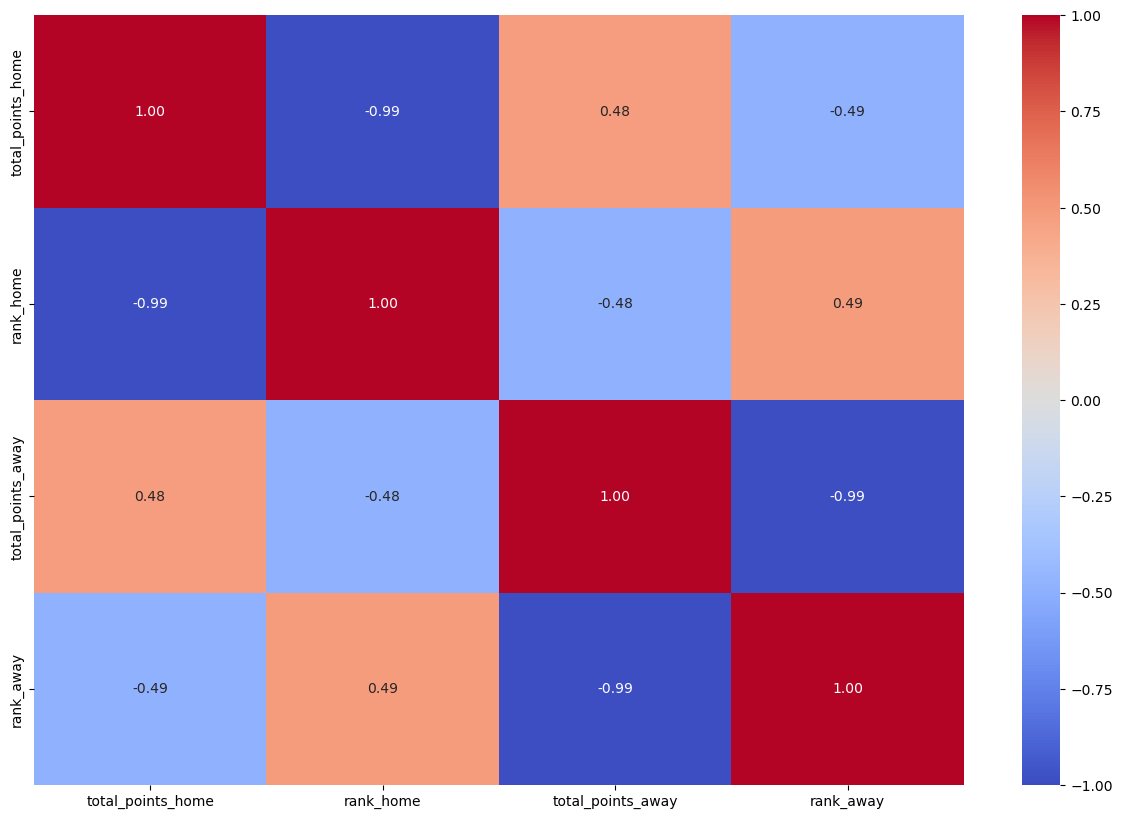

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr(),
            annot=True, fmt=".2f", cmap='coolwarm', vmax=1, vmin=-1)
plt.show()

Ahora, creamos columnas que ayudarán en la creación de las features: ranking difference, points won at the game vs. team faced rank, and goals difference in the game. Todas las features que no sean diferencias deben crearse para los dos equipos (local y visitante).

In [353]:
df["rank_dif"] = df["rank_home"] - df["rank_away"] # diferencia de rango
df["sg"] = df["home_score"] - df["away_score"] # diferencia de goles
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"] # puntos del equipo local por rango del equipo visitante
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"] # puntos del equipo visitante por rango del equipo local

In [354]:
df.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points,rank_dif,sg,points_home_by_rank,points_away_by_rank
24095,2024-06-14,El Salvador,Peru,0.0,1.0,Friendly,Philadelphia,United States,True,1306.14,...,1512.68,33.0,-2.0,1,0,3,48.0,-1.0,0.000000,0.037037
24096,2024-06-15,Hungary,Switzerland,1.0,3.0,UEFA Euro,Cologne,Germany,True,1532.20,...,1613.44,19.0,0.0,1,0,3,7.0,-2.0,0.000000,0.115385
24097,2024-06-15,Spain,Croatia,3.0,0.0,UEFA Euro,Berlin,Germany,True,1727.50,...,1717.57,10.0,0.0,0,3,0,-2.0,3.0,0.300000,0.000000
24098,2024-06-15,Italy,Albania,2.0,1.0,UEFA Euro,Dortmund,Germany,True,1724.60,...,1382.69,66.0,2.0,0,3,0,-57.0,1.0,0.045455,0.000000
24099,2024-06-15,Vanuatu,Solomon Islands,1.0,0.0,Oceania Nations Cup,Port Vila,Vanuatu,False,972.14,...,1113.57,132.0,1.0,0,3,0,40.0,1.0,0.022727,0.000000


Para crear las features, separaré el conjunto de datos del equipo local y del equipo visitante, los concatenaré y calcularé los valores de los juegos anteriores. Después de eso, los separaré nuevamente y los fusionaré (merge), recuperando el conjunto de datos original. Este proceso optimiza la creación de las features.

In [355]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [356]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [357]:
team_stats = pd.concat([home_team, away_team])

In [358]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

In [359]:
team_stats.shape, home_team.shape, away_team.shape

((5594, 12), (2797, 12), (2797, 12))

In [360]:
team_stats.tail()

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
24095,2024-06-14,Peru,1.0,0.0,33.0,81.0,-2.0,1512.68,1,48.0,0.037037,3
24096,2024-06-15,Switzerland,3.0,1.0,19.0,26.0,0.0,1616.41,1,7.0,0.115385,3
24097,2024-06-15,Croatia,0.0,3.0,10.0,8.0,0.0,1721.07,0,-2.0,0.000000,0
24098,2024-06-15,Albania,1.0,2.0,66.0,9.0,2.0,1375.10,0,-57.0,0.000000,0
24099,2024-06-15,Solomon Islands,0.0,1.0,132.0,172.0,1.0,1111.02,0,40.0,0.000000,0


Ahora, tenemos el dataset listo para crear features que nos ayuden a predecir. Estas son:

- Mean goals of the team in World Cup Cycle.
- Mean goals of the team in last 5 games.
- Mean goals suffered of the team in World Cup Cycle.
- Mean goals suffered of the team in last 5 games.
- Mean FIFA Rank that team faced in World Cup Cycle.
- Mean FIFA Rank that team faced in last 5 games.
- FIFA Points won at the cycle.
- FIFA Points won in last 5 games.
- Mean game points at the Cycle.
- Mean game points at last 5 games.
- Mean game points by rank faced at the Cycle.
- Mean game points by rank faced at last 5 games.

In [361]:
'''This Python code is iterating over each row of a DataFrame team_stats and calculating various statistics for each team based on their past games. Here's a step-by-step explanation:

For each row in team_stats, it identifies the team and the date of the game.

It then filters team_stats to get all past games for the current team (past_games), and sorts them in descending order by date. It also gets the last 5 games (last5).

It calculates the mean score (goals), suffered score (goals_suf), rank (rank), total points (points), team points (gp), and points by rank (gp_rank) for all past games. It does the same calculations for the last 5 games (variables with _l5 suffix).

If there are at least one game in the last 5 games, it calculates the points gained (points) and points gained in the last 5 games (points_l5) as the difference between the total points of the most recent and the oldest game in the respective periods. If there are no games in the last 5 games, it sets these values to 0.

Finally, it appends all these calculated values to the stats_val list.'''

stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [362]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [363]:
full_df

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,...,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,game_points_rank_mean,game_points_rank_mean_l5
0,2021-06-13,South Korea,2.0,1.0,39.0,93.0,0.0,1460.25,0,-54.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,2021-06-13,Sudan,0.0,1.0,123.0,87.0,0.0,1149.14,1,36.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,2021-06-13,Tanzania,2.0,0.0,137.0,115.0,0.0,1088.05,0,22.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,2021-06-13,Austria,3.0,1.0,23.0,62.0,0.0,1523.42,0,-39.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,2021-06-13,Netherlands,3.0,2.0,16.0,24.0,0.0,1598.04,0,-8.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5589,2024-06-14,Peru,1.0,0.0,33.0,81.0,-2.0,1512.68,1,48.0,...,1.000000,0.8,42.175000,94.8,0.80,-19.89,1.450000,1.6,0.039132,0.016131
5590,2024-06-15,Switzerland,3.0,1.0,19.0,26.0,0.0,1616.41,1,7.0,...,1.166667,0.4,52.194444,55.8,7.23,-31.94,1.611111,1.6,0.079487,0.032079
5591,2024-06-15,Croatia,0.0,3.0,10.0,8.0,0.0,1721.07,0,-2.0,...,0.850000,0.6,42.675000,49.4,111.82,5.69,2.000000,2.6,0.142133,0.122398
5592,2024-06-15,Albania,1.0,2.0,66.0,9.0,2.0,1375.10,0,-57.0,...,1.068966,1.0,78.413793,103.8,22.86,-14.14,1.379310,1.4,0.018789,0.009747


Ahora se divide nuevamente el dataset entre los equipos visitantes y locales:

In [364]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [365]:
home_team_stats.columns[-12:] # columnas añadidas

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [366]:
# Nos quedamos con las columnas añadidas
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [367]:
# Agregamos el prefijo 'home_' a las columnas de home_team_stats y 'away_' a las columnas de away_team_stats
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Para unificar el dataset, es necesario agregar los sufijos home_ y away_ para cada columna. Después de eso, los datos están listos para fusionarse (merge).

In [368]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [373]:
home_team_stats.shape, away_team_stats.shape

((2797, 12), (2797, 12))

In [369]:
match_stats.shape, df.shape

((2797, 24), (2797, 24))

In [378]:
full_df = pd.concat([df.reset_index(drop=True), match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [379]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

Ahora, para cuantificar la importancia del juego, se crea una columna que para diferenciar si es amistoso o un torneo.

In [380]:
full_df.shape

(2797, 48)

In [381]:
def find_friendly(x):
    if x == "Friendly":
        return 0
    else: return 1

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [382]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [384]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [385]:
full_df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,...,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
0,2021-06-13,South Korea,Lebanon,2.0,1.0,FIFA World Cup qualification,Goyang,South Korea,False,1460.25,...,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,False,True
1,2021-06-13,Sudan,Zambia,0.0,1.0,Friendly,Omdurman,Sudan,False,1149.14,...,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,True,False
2,2021-06-13,Tanzania,Malawi,2.0,0.0,Friendly,Dar es Salaam,Tanzania,False,1088.05,...,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,True,False
3,2021-06-13,Austria,North Macedonia,3.0,1.0,UEFA Euro,Bucharest,Romania,True,1523.42,...,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,False,True
4,2021-06-13,Netherlands,Ukraine,3.0,2.0,UEFA Euro,Amsterdam,Netherlands,False,1598.04,...,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,2024-06-14,El Salvador,Peru,0.0,1.0,Friendly,Philadelphia,United States,True,1306.14,...,42.175000,94.8,0.80,-19.89,1.450000,1.6,0.039132,0.016131,True,False
2793,2024-06-15,Hungary,Switzerland,1.0,3.0,UEFA Euro,Cologne,Germany,True,1532.20,...,52.194444,55.8,7.23,-31.94,1.611111,1.6,0.079487,0.032079,False,True
2794,2024-06-15,Spain,Croatia,3.0,0.0,UEFA Euro,Berlin,Germany,True,1727.50,...,42.675000,49.4,111.82,5.69,2.000000,2.6,0.142133,0.122398,False,True
2795,2024-06-15,Italy,Albania,2.0,1.0,UEFA Euro,Dortmund,Germany,True,1724.60,...,78.413793,103.8,22.86,-14.14,1.379310,1.4,0.018789,0.009747,False,True


And, after that, we select only columns that will help in Features' analysis.

In [386]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
2792,2024-06-14,El Salvador,Peru,81.0,33.0,0.0,1.0,1,48.0,3.0,...,0.674419,0.4,0.012216,0.003814,1.450000,1.6,0.039132,0.016131,True,False
2793,2024-06-15,Hungary,Switzerland,26.0,19.0,1.0,3.0,1,7.0,-1.0,...,1.787879,2.4,0.100292,0.039597,1.611111,1.6,0.079487,0.032079,False,True
2794,2024-06-15,Spain,Croatia,8.0,10.0,3.0,0.0,0,-2.0,0.0,...,2.052632,2.0,0.097319,0.059661,2.000000,2.6,0.142133,0.122398,False,True
2795,2024-06-15,Italy,Albania,9.0,66.0,2.0,1.0,0,-57.0,0.0,...,1.789474,2.2,0.244825,0.054149,1.379310,1.4,0.018789,0.009747,False,True
2796,2024-06-15,Vanuatu,Solomon Islands,172.0,132.0,1.0,0.0,0,40.0,2.0,...,0.636364,0.8,0.003908,0.004916,2.100000,2.0,0.012460,0.011577,False,True


In [387]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                   90
home_goals_mean_l5                90
home_goals_suf_mean               90
home_goals_suf_mean_l5            90
home_rank_mean                    90
home_rank_mean_l5                 90
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  105
away_goals_mean_l5               105
away_goals_suf_mean              105
away_goals_suf_mean_l5           105
away_rank_mean                   105
away_rank_mean_l5                105
away_points_mean                   0
away_points_mean_l5                0
h

The games with NA are the ones who mean could not be calculated (games from the beginning of the dataset). Those will be dropped.

In [388]:
base_df_no_fg = base_df.dropna()

# Data Analysis

Ahora, necesitamos analizar todas las features que se crearon y verificar si tienen poder predictivo. Además, si no lo tienen, necesitamos crear algunas que sí lo tengan (diferencias entre los equipos locales y visitantes). Para analizar el poder predictivo, asignaré los juegos empatados como una derrota para equipo local y crearé un problema binario.

In [389]:
df = base_df_no_fg.copy()

In [390]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

In [391]:
df.columns

Index(['date', 'home_team', 'away_team', 'rank_home', 'rank_away',
       'home_score', 'away_score', 'result', 'rank_dif', 'rank_change_home',
       'rank_change_away', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
       'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
       'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
       'away_points_mean', 'away_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 'is_friendly_0', 'is_friendly_1',
       'target'],
      dtype='object')

Análisis que se realizará:

- Violín y boxplot para analizar si las características tienen diferentes distribuciones según el objetivo.

- Diagramas de dispersión para analizar correlaciones.

In [392]:
df.columns[8:20].values

array(['rank_dif', 'rank_change_home', 'rank_change_away',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'away_goals_mean'],
      dtype=object)

In [393]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [394]:
'''This Python code is performing standardization and reshaping on two datasets, data1 and data2.

Here's a step-by-step explanation:

scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std(): This line is standardizing the data1 
dataset, excluding the last row ([:-1]). Standardization is a scaling technique where values are 
centered around the mean with a unit standard deviation. This means that the mean of the attribute 
becomes zero and the resultant distribution has a unit standard deviation.

scaled["target"] = data1["target"]: This line is adding a new column to the scaled DataFrame, named 
"target". The values for this column are being taken from the "target" column of the data1 DataFrame.

violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value"): This line is 
reshaping the scaled DataFrame from wide format to long format, where each row is a unique id-variable 
combination. The id_vars parameter is the column that will be used as identifier variables, var_name 
is the name to use for the variable column and value_name is the name to use for the value column.

The same steps are repeated for the data2 dataset.'''

scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

In [395]:
violin1

,target,features,value
0,0,rank_dif,-0.552847
1,0,rank_dif,-0.009818
2,1,rank_dif,-0.149954
3,0,rank_dif,-0.202506
4,0,rank_dif,-0.973256
...,...,...,...
31939,0,away_goals_mean,-0.138495
31940,1,away_goals_mean,-0.294090
31941,1,away_goals_mean,0.504245
31942,0,away_goals_mean,0.673840


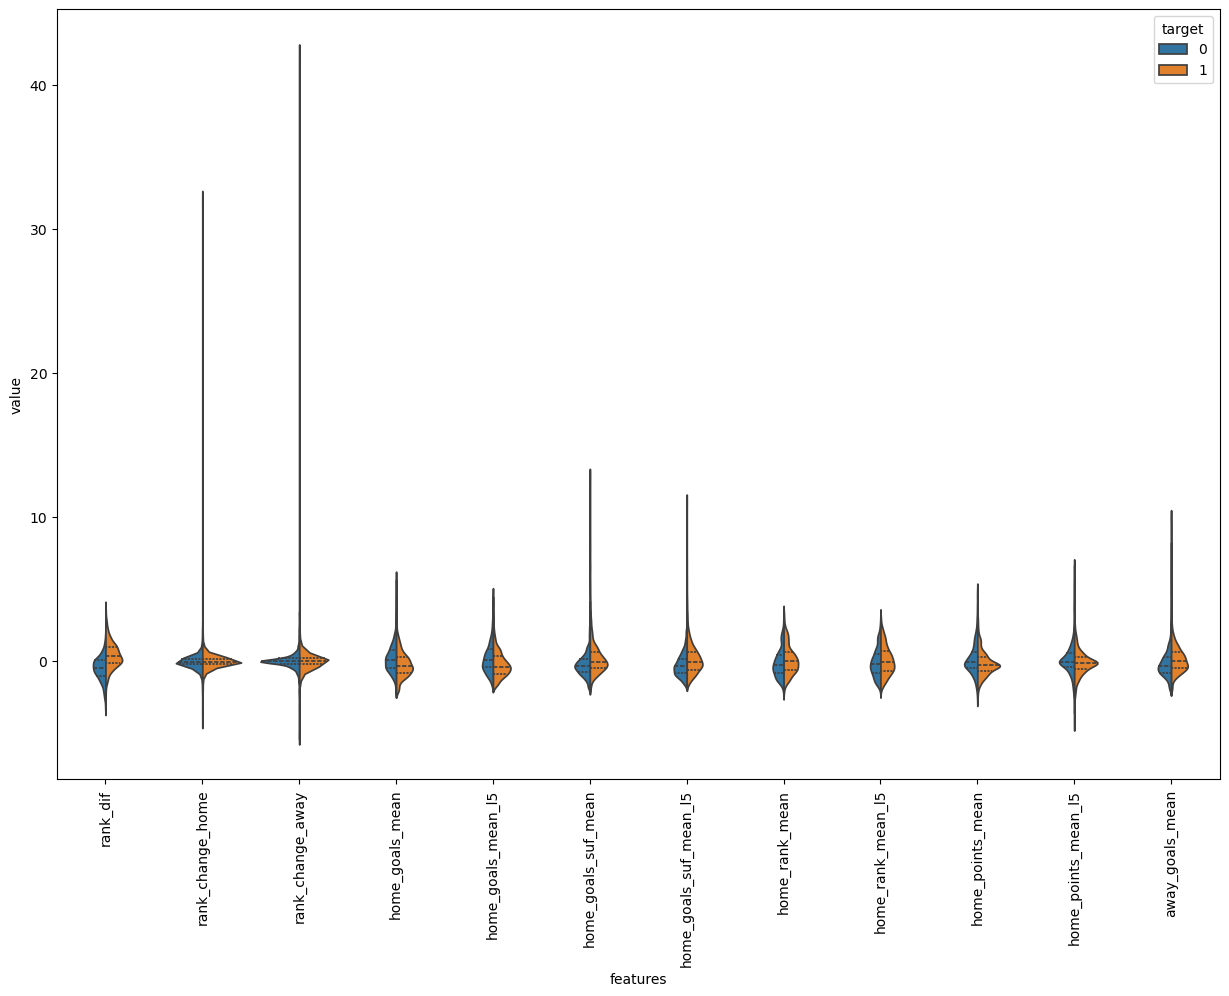

In [396]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

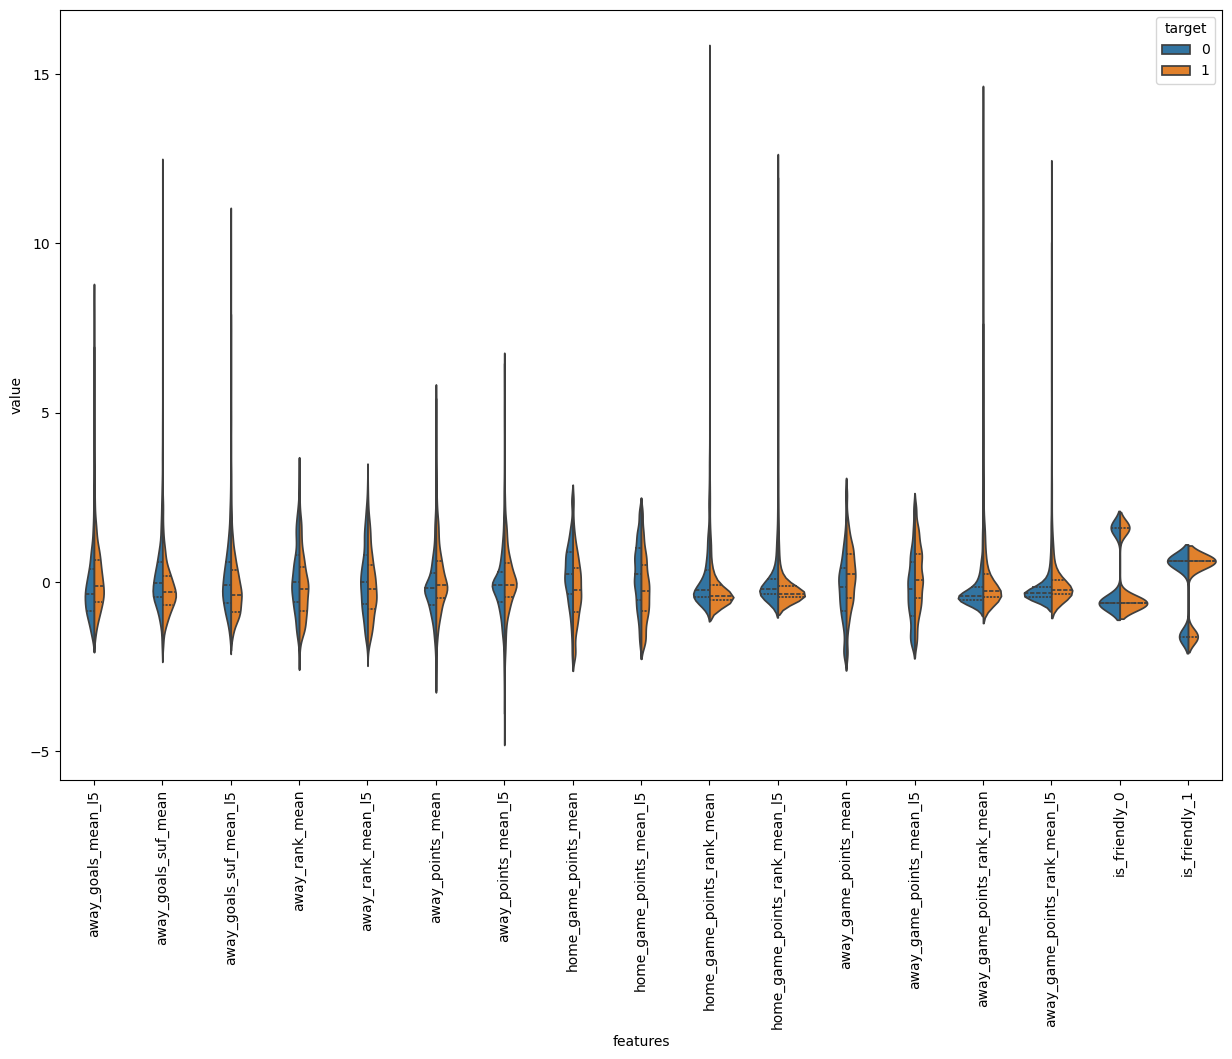

In [397]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Con los gráficos, encontramos que la diferencia de rango (rank_dif) es el único buen separador de los datos. Pero podemos crear features que obtengan las diferencias entre el equipo local y visitante y analizar si son buenas separando los datos.

Se toma la diferencia entre las features anteriores para ver si separa mejor los datos:

In [398]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

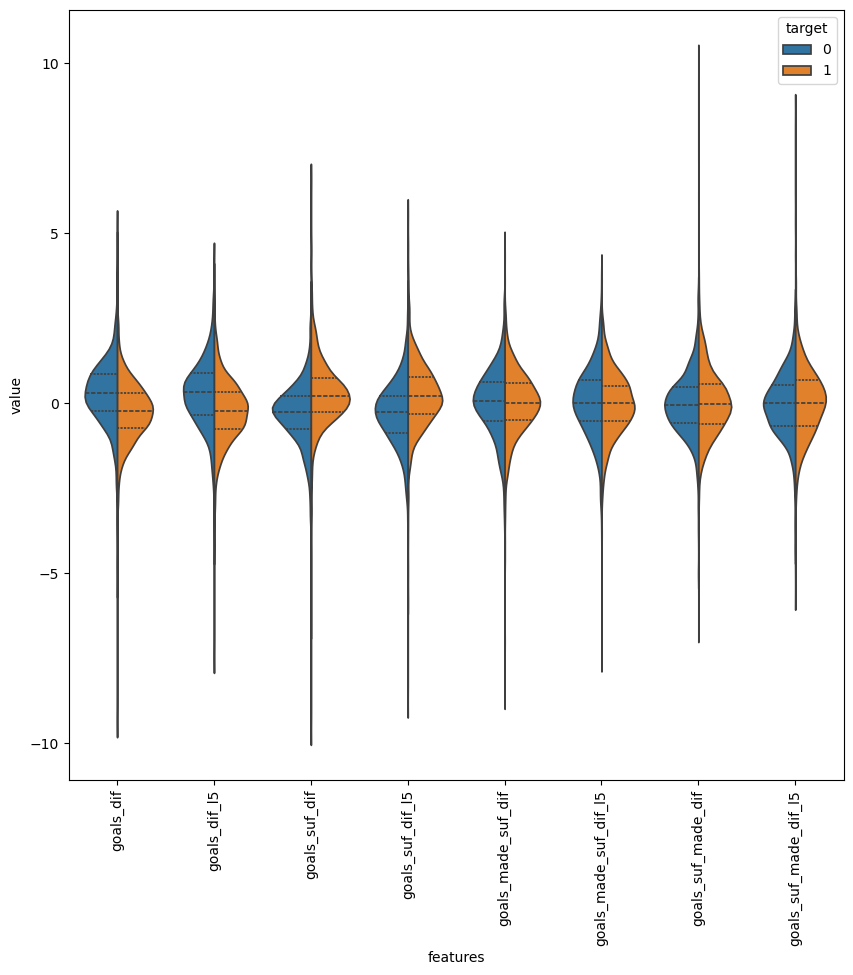

In [399]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Con ese gráfico, vemos que la diferencia de goles son un buen separador, y la diferencia de goles sufridos también. Las diferencias entre los goles marcados y sufridos de los equipos no son muy buenos separadores.

Ahora tenemos 5 features:

- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5

Podemos crear otras features, como diferencias de puntos obtenidos, diferencias de puntos obtenidos por rango enfrentado y diferencias de rango enfrentado.

In [400]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Además, podemos calcular los goles marcados y sufridos por rango y analizar esta diferencia.

In [401]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

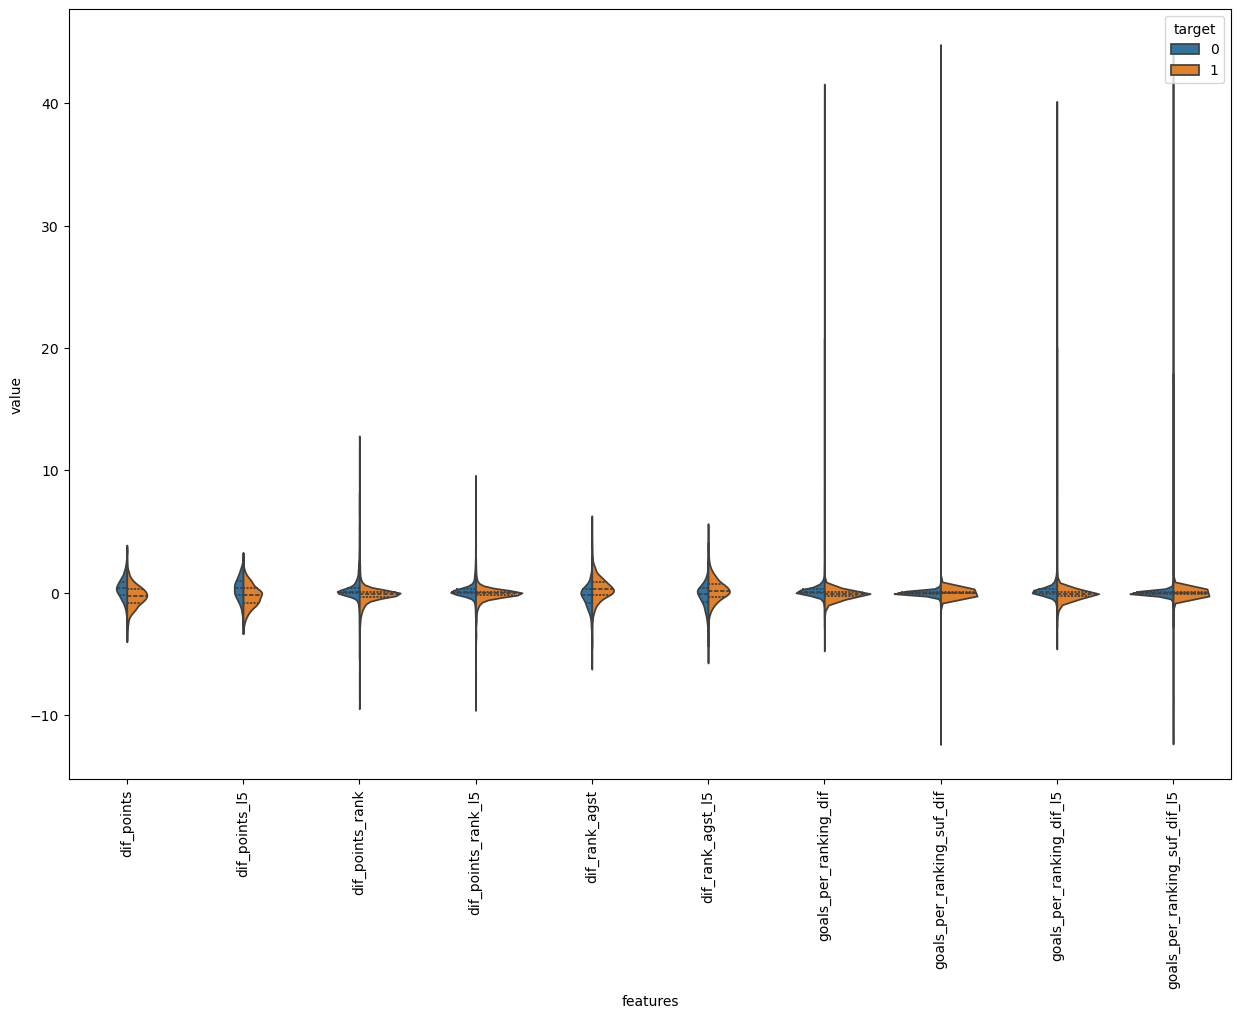

In [402]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Veamos la box plot:

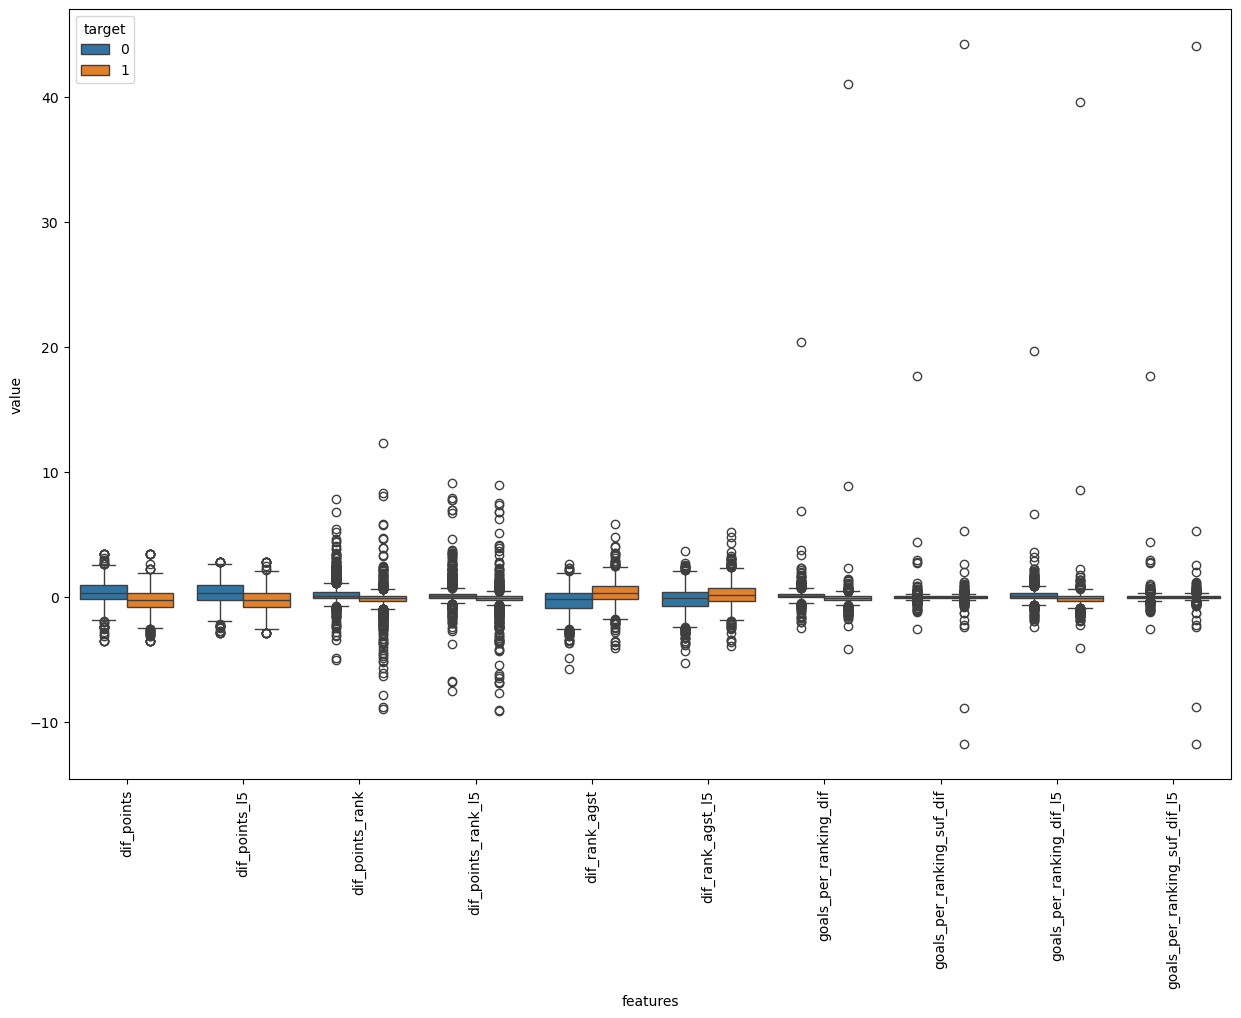

In [403]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Diferencia de puntos (full and last 5 games), diferencia de puntos por rango enfrentado (full and last 5 games) y diferencia de rango enfrentado (full and last 5 games) son buenas features. Las distribuciones de las features se analizarán usando scatter plots:

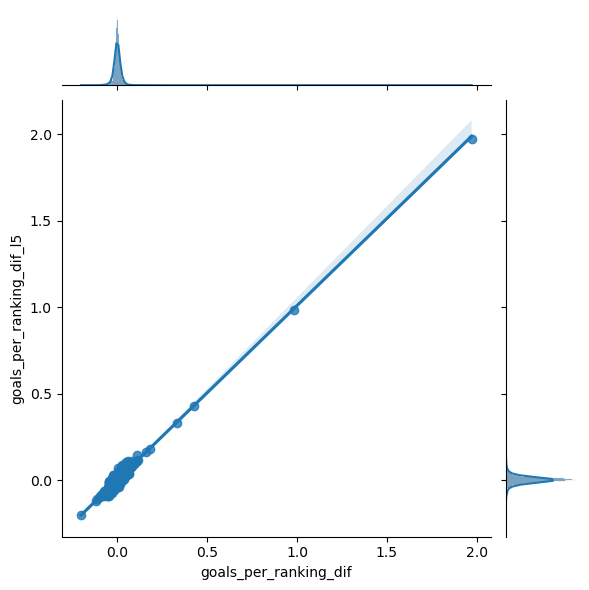

In [404]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Tienen distribución similar, por lo que usaremos solo 'goals_per_ranking_dif'

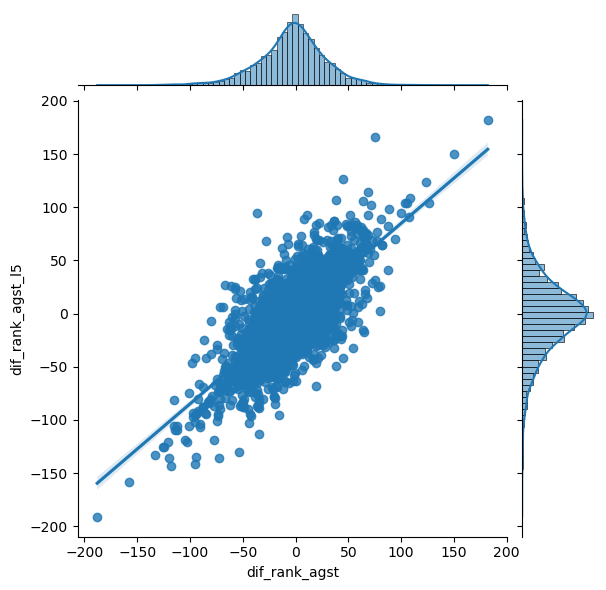

In [405]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

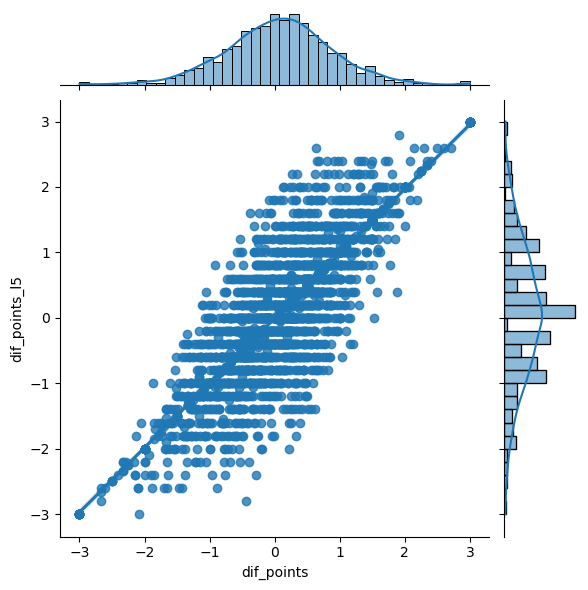

In [406]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

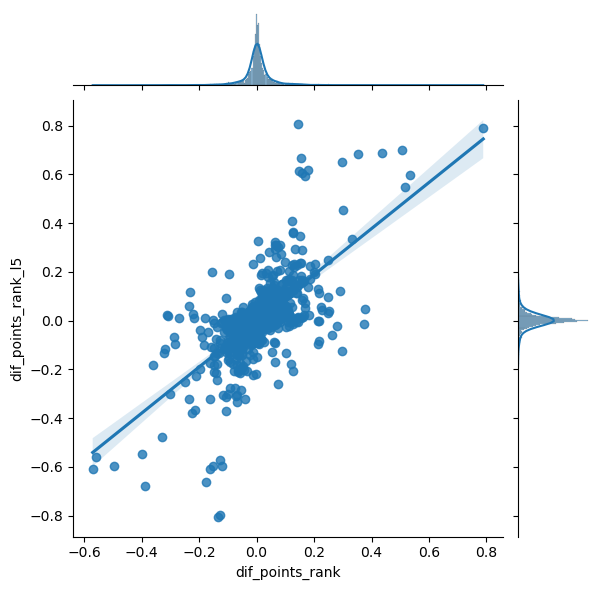

In [407]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

En cuanto a las diferencias de rango enfrentado, puntos por rango enfrentado y puntos promedio por rango enfrentado, las dos versiones (full and 5 games) no son tan similares. Entonces usaremos ambos.

Las features finales son:


- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [408]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    # 'home_game_points_mean', 'home_game_points_mean_l5', 'away_game_points_mean', 'away_game_points_mean_l5',
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]

    # base.loc[:, "dif_points"] = base["home_game_points_mean"] - base["away_game_points_mean"]
    # base.loc[:, "dif_points_l5"] = base["home_game_points_mean_l5"] - base["away_game_points_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]] #"dif_points", "dif_points_l5",
    return model_df

In [409]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [410]:
model_db = create_db(df)

In [411]:
model_db.reset_index(drop=True, inplace=True)

In [412]:
model_db.head()

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
0,Ukraine,North Macedonia,0,-38.0,1.0,1.0,0.0,0.0,0.081522,-7.0,-7.0,0.000000,0.000000,False,True
1,Netherlands,Austria,0,-7.0,0.0,0.0,1.0,1.0,0.076613,-38.0,-38.0,0.076613,0.076613,False,True
2,Colombia,Venezuela,1,-15.0,1.0,1.0,-3.0,-3.0,0.018868,50.0,50.0,0.056604,0.056604,False,True
3,Sweden,Slovakia,0,-18.0,-2.0,-2.0,-1.0,-1.0,-0.095238,-15.0,-15.0,0.023810,0.023810,False,True
4,Chile,Bolivia,0,-62.0,0.0,0.0,-2.0,-2.0,0.096429,-27.0,-27.0,0.125000,0.125000,False,True


In [413]:
model_db.to_csv('model_db.csv', index=False)

In [414]:
model_db = pd.read_csv("model_db.csv")

# The model

Ahora que tenemos un dataset listo, podemos comenzar con el modelado.

Se probarán los siguientes modelos: Random Forest, Gradient Boosting, XGBoost y una Red Neuronal. El seleccionado será el de mejor recall.

In [415]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [416]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [418]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

model_db.iloc[:, 2:].head()

X = model_db.iloc[:, 3:]
y = model_db[["target"]]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 0.2, random_state=2)

features_num = X.columns[X.dtypes != np.object_]

transformer_num = make_pipeline(
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
)


X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [498]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def analyze(model):
    fpr, tpr, _ = roc_curve(y_val, model.predict_proba(X_val)[:,1]) #test AUC
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on validation and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val, model.predict(X_val))
    sns.heatmap(cm, annot=True, fmt="d")

Gradient Boosting Classifier:

In [526]:
gb = GradientBoostingClassifier(random_state=5)

params = {
    "learning_rate": [0.05, 0.1],  # Lower learning rates
    "min_samples_split": [10, 20],  # Increased minimum samples required to split
    "min_samples_leaf": [10],  # Increased minimum samples required at each leaf node
    "max_depth": [3, 4],  # Limited maximum depth
    "max_features": ["sqrt"],  # Consider using a subset of features for the best split
    "n_estimators": [100, 200],  # Adjust number of trees
    "subsample": [0.8, 0.9]  # Use a fraction of samples
}

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 4],
                         'max_features': ['sqrt'], 'min_samples_leaf': [10],
                         'min_samples_split': [10, 20],
                         'n_estimators': [100, 200], 'subsample': [0.8, 0.9]},
             verbose=False)

In [527]:
gb = gb_cv.best_estimator_

In [528]:
gb

GradientBoostingClassifier(learning_rate=0.05, max_features='sqrt',
                           min_samples_leaf=10, min_samples_split=10,
                           random_state=5, subsample=0.8)

In [529]:
print(f"Training Score: {gb.score(X_train, y_train)}")
print(f"Validation Score: {gb.score(X_val, y_val)}")
print(f"Test Score: {gb.score(X_test, y_test)}")

Training Score: 0.7576291079812206
Validation Score: 0.7464788732394366
Test Score: 0.7091932457786116


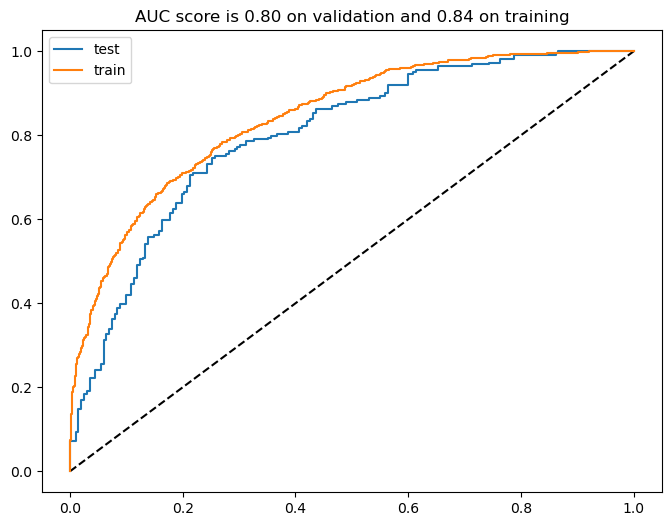

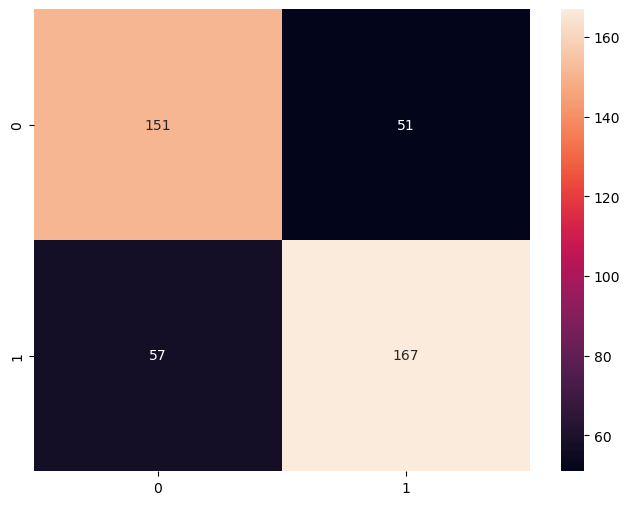

In [530]:
analyze(gb)

Random Forest:

In [493]:
params_rf = {
    "max_depth": [10],  # Reduced maximum depth
    "min_samples_split": [10, 12],  # Increased minimum samples required to split
    "max_leaf_nodes": [80, 100],  # Adjusted max leaf nodes
    "min_samples_leaf": [15, 20],  # Increased minimum samples required at each leaf node
    "n_estimators": [100, 150, 200],  # Adjusted number of trees
    "max_features": ["sqrt", "log2"],  # Adjusted max features to consider for best split
}

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = 2, verbose = False)

rf_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=2,
             param_grid={'max_depth': [10], 'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [80, 100],
                         'min_samples_leaf': [15, 20],
                         'min_samples_split': [10, 12],
                         'n_estimators': [100, 150, 200]},
             verbose=False)

In [494]:
rf = rf_cv.best_estimator_

In [495]:
rf

RandomForestClassifier(max_depth=10, max_leaf_nodes=80, min_samples_leaf=15,
                       min_samples_split=10, n_estimators=150, random_state=1)

In [496]:
print(f"Training Score: {rf.score(X_train, y_train)}")
print(f"Validation Score: {rf.score(X_val, y_val)}")
print(f"Test Score: {rf.score(X_test, y_test)}")

Training Score: 0.789906103286385
Validation Score: 0.7535211267605634
Test Score: 0.7110694183864915


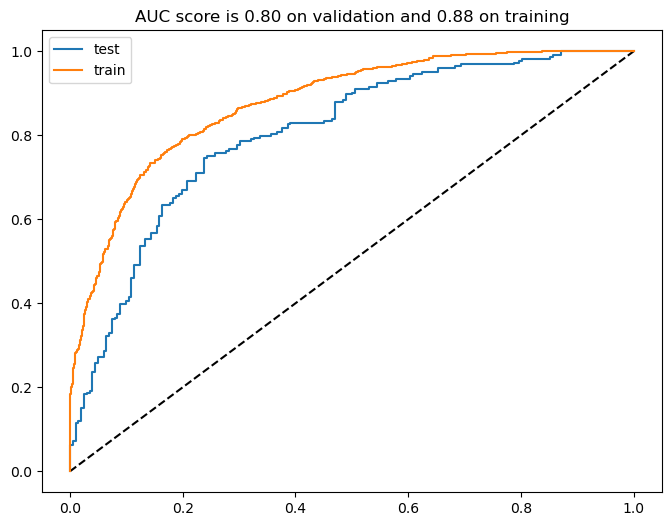

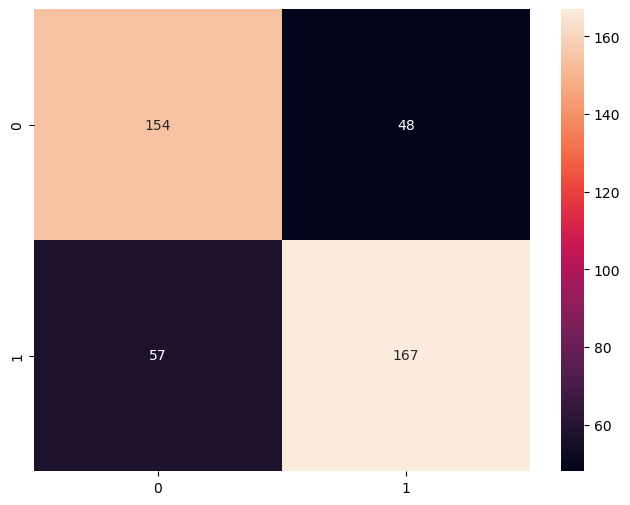

In [497]:
analyze(rf)

XGBoost:

In [533]:
from xgboost import XGBClassifier

In [574]:
xgb = XGBClassifier(
    learning_rate=0.05,  # Lower learning rate
    early_stopping_rounds=10,  # Early stopping
    n_estimators=1000,  # More trees, but use early stopping
    max_depth=5,  # Reduced depth
    n_jobs=2,  # Parallel computation
    subsample=0.8,  # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    use_label_encoder=False,  # Avoids a deprecation warning
)

# Fit model using early stopping
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=2,
              num_parallel_tree=None, random_state=None, ...)

In [575]:
print(f"Training Score: {xgb.score(X_train, y_train)}")
print(f"Validation Score: {xgb.score(X_val, y_val)}")
print(f"Test Score: {xgb.score(X_test, y_test)}")

Training Score: 0.8051643192488263
Validation Score: 0.7347417840375586
Test Score: 0.724202626641651


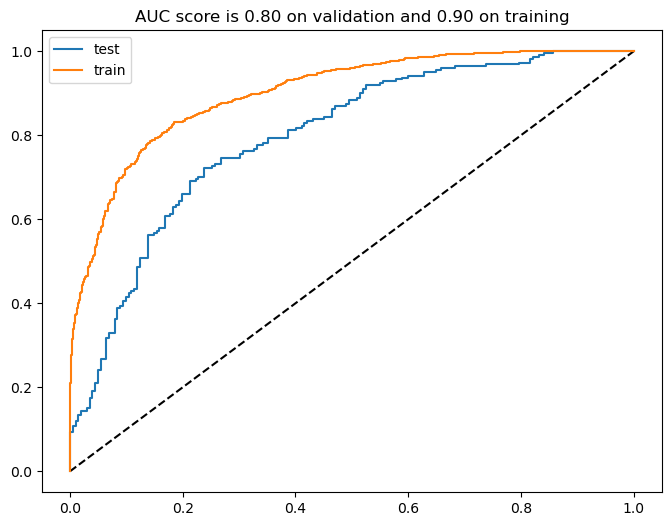

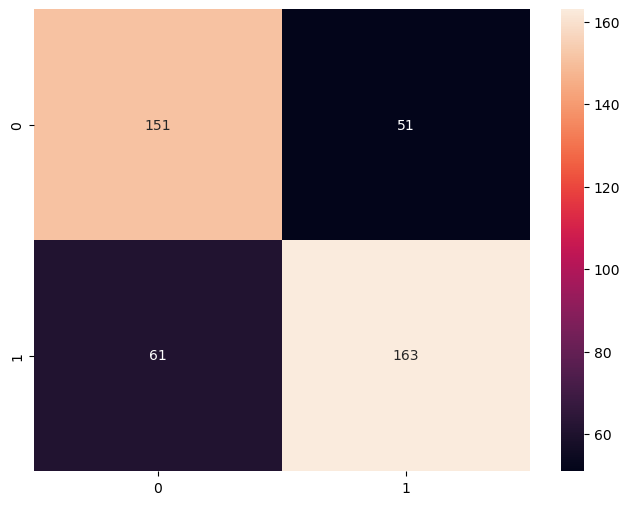

In [573]:
analyze(xgb)

Neural Network:

In [580]:
np.object = np.object_
np.bool = np.bool_
np.int = np.int_
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [577]:
input_shape = [X_train.shape[1]]

In [578]:
X_train.shape

(1704, 12)

In [587]:
RN = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

<Axes: title={'center': 'Accuracy'}>

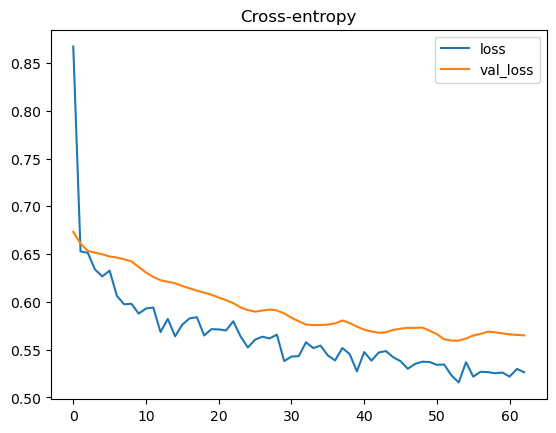

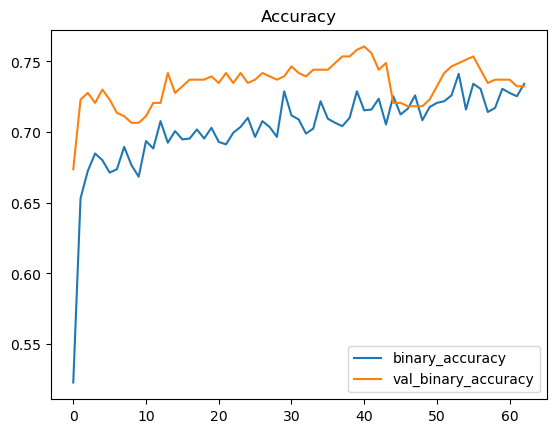

In [588]:
RN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
history = RN.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [590]:
test_loss, test_acc = RN.evaluate(X_test, y_test)
val_loss, val_acc = RN.evaluate(X_val, y_val)
train_loss, train_acc = RN.evaluate(X_train, y_train)
print('Test accuracy:', test_acc)
print('Val accuracy:', val_acc)
print('Train accuracy:', train_acc)

54/54 [==============================] - 0s 2ms/step - loss: 0.5204 - binary_accuracy: 0.7441
Test accuracy: 0.6998124122619629
Val accuracy: 0.7464788556098938
Train accuracy: 0.7441314458847046


Me quedaré con el XGBoost ya que es el que obtuvo un mayor score en los datos de test (xgb).

# Simulation Copa América

The first thing is to create FIFA World Cup games. To do this, I'll get in the wikipedia the teams and group phase matches.

In [615]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2024_Copa_Am%C3%A9rica#Group_stage")

In [616]:
match = dfs[15:42]
matches = []
groups = ["A", "B", "C", "D"]
j = 5
g = 0
for i in range(len(match)):
    if len(match[i].columns) == 3:
        j += 1 
        k = j%6    
        if k == 0 and g != 4:
            g +=1
        team_1 = match[i].columns.values[0]
        team_2 = match[i].columns.values[-1]
        
        matches.append([groups[g-1] , team_1, team_2])

In [617]:
matches

[['A', 'Argentina', 'Canada'],
 ['A', 'Peru', 'Chile'],
 ['A', 'Peru', 'Canada'],
 ['A', 'Chile', 'Argentina'],
 ['A', 'Argentina', 'Peru'],
 ['A', 'Canada', 'Chile'],
 ['B', 'Ecuador', 'Venezuela'],
 ['B', 'Mexico', 'Jamaica'],
 ['B', 'Ecuador', 'Jamaica'],
 ['B', 'Venezuela', 'Mexico'],
 ['B', 'Mexico', 'Ecuador'],
 ['B', 'Jamaica', 'Venezuela'],
 ['C', 'United States', 'Bolivia'],
 ['C', 'Uruguay', 'Panama'],
 ['C', 'Panama', 'United States'],
 ['C', 'Uruguay', 'Bolivia'],
 ['C', 'United States', 'Uruguay'],
 ['C', 'Bolivia', 'Panama'],
 ['D', 'Colombia', 'Paraguay'],
 ['D', 'Brazil', 'Costa Rica'],
 ['D', 'Colombia', 'Costa Rica'],
 ['D', 'Paraguay', 'Brazil'],
 ['D', 'Brazil', 'Colombia']]

In [594]:
# groups = ["A", "B", "C", "D"]
# g = 0
# for i in range(len(matches)):
#     j = i%6    
#     if j == 0:
#         g +=1

#     matches[i][0] = groups[g-1]

In [625]:
url = "https://en.wikipedia.org/wiki/2024_Copa_Am%C3%A9rica#Draw_2"

# Lee todas las tablas en la página
tables = pd.read_html(url)

# Suponiendo que la tabla de equipos está en la primera posición y la de partidos de la fase de grupos en la segunda
teams_df = tables[6:10]
group_phase_matches_df = tables[10:14]

# print(teams_df)
print(group_phase_matches_df)

[  Pos       Team
0  A1  Argentina
1  A2       Peru
2  A3      Chile
3  A4     Canada,   Pos       Team
0  B1     Mexico
1  B2    Ecuador
2  B3  Venezuela
3  B4    Jamaica,   Pos           Team
0  C1  United States
1  C2        Uruguay
2  C3         Panama
3  C4        Bolivia,   Pos        Team
0  D1      Brazil
1  D2    Colombia
2  D3    Paraguay
3  D4  Costa Rica]


In [624]:
tables[13]

,Pos,Team
0,D1,Brazil
1,D2,Colombia
2,D3,Paraguay
3,D4,Costa Rica


In [626]:
group_phase_matches_df[0]

,Pos,Team
0,A1,Argentina
1,A2,Peru
2,A3,Chile
3,A4,Canada


In [627]:
pd_group_phase_matches_df = group_phase_matches_df[0].copy()
for i in range(1, len(group_phase_matches_df)):
    pd_group_phase_matches_df = pd.concat([pd_group_phase_matches_df, group_phase_matches_df[i]], axis=0)


In [628]:
groups = ["A", "B", "C", "D"]
for g in range(0, len(groups)):
    i = g*4
    pd_group_phase_matches_df['Pos'][i:i+4] = groups[g]

C:\Users\oscar\AppData\Local\Temp\ipykernel_11344\1478958612.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pd_group_phase_matches_df['Pos'][i:i+4] = groups[g]
C:\Users\oscar\AppData\Local\Temp\ipykernel_11344\1478958612.py:4: FutureWar

In [629]:
pd_group_phase_matches_df

,Pos,Team
0,A,Argentina
1,A,Peru
2,A,Chile
3,A,Canada
0,B,Mexico
1,B,Ecuador
2,B,Venezuela
3,B,Jamaica
0,C,United States
1,C,Uruguay


In [630]:
group_dict = {}
for group in pd_group_phase_matches_df['Pos'].unique():
    group_dict[group] = []
    for team in pd_group_phase_matches_df[pd_group_phase_matches_df['Pos'] == group]['Team']:
        group_dict[group].append([team, 0, []])

In [631]:
table = group_dict
table, matches

({'A': [['Argentina', 0, []],
   ['Peru', 0, []],
   ['Chile', 0, []],
   ['Canada', 0, []]],
  'B': [['Mexico', 0, []],
   ['Ecuador', 0, []],
   ['Venezuela', 0, []],
   ['Jamaica', 0, []]],
  'C': [['United States', 0, []],
   ['Uruguay', 0, []],
   ['Panama', 0, []],
   ['Bolivia', 0, []]],
  'D': [['Brazil', 0, []],
   ['Colombia', 0, []],
   ['Paraguay', 0, []],
   ['Costa Rica', 0, []]]},
 [['A', 'Argentina', 'Canada'],
  ['A', 'Peru', 'Chile'],
  ['A', 'Peru', 'Canada'],
  ['A', 'Chile', 'Argentina'],
  ['A', 'Argentina', 'Peru'],
  ['A', 'Canada', 'Chile'],
  ['B', 'Ecuador', 'Venezuela'],
  ['B', 'Mexico', 'Jamaica'],
  ['B', 'Ecuador', 'Jamaica'],
  ['B', 'Venezuela', 'Mexico'],
  ['B', 'Mexico', 'Ecuador'],
  ['B', 'Jamaica', 'Venezuela'],
  ['C', 'United States', 'Bolivia'],
  ['C', 'Uruguay', 'Panama'],
  ['C', 'Panama', 'United States'],
  ['C', 'Uruguay', 'Bolivia'],
  ['C', 'United States', 'Uruguay'],
  ['C', 'Bolivia', 'Panama'],
  ['D', 'Colombia', 'Paraguay'],
  ['

Usaré las estadísticas del último juego como estadísticas de cada equipo involucrado en el juego. Por ejemplo, para Brasil vs Colombia, las estadísticas de Brasil son las que tuvieron en el último partido y las de Colombia también.

In [632]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [633]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Ahora podemos simular.

Dado que el modelo simula si el equipo 1 ganará o no, es necesario crear algunos criterios para definir un empate. Además, como no tenemos la ventaja de jugar en casa en la Copa América, la idea es predecir el partido dos veces, cambiando el equipo 1 y el equipo 2. El equipo con mayor media de probabilidades será asignado como ganador. En la fase de grupos, si el "equipo local" gana como equipo 1 y pierde como equipo 2, o si el "equipo local" gana como equipo 2 y pierde como equipo 1, se asignará un empate en ese partido.

In [634]:
from operator import itemgetter

In [636]:
model = xgb

In [637]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = model.predict_proba([features_g1])
    probs_g2 = model.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Argentina vs. Canada: Winner Argentina with 0.76 probability
Group A - Peru vs. Chile: Draw
Group A - Peru vs. Canada: Draw
Group A - Chile vs. Argentina: Winner Argentina with 0.74 probability
Group A - Argentina vs. Peru: Winner Argentina with 0.78 probability
Group A - Canada vs. Chile: Winner Chile with 0.73 probability


Group A advanced: 
Argentina -------- 9
Chile -------- 4
Peru -------- 2
Canada -------- 1


---------- Starting Analysis for Group B ----------
Group B - Ecuador vs. Venezuela: Winner Ecuador with 0.71 probability
Group B - Mexico vs. Jamaica: Winner Mexico with 0.82 probability
Group B - Ecuador vs. Jamaica: Winner Ecuador with 0.80 probability
Group B - Venezuela vs. Mexico: Winner Mexico with 0.65 probability
Group B - Mexico vs. Ecuador: Winner Mexico with 0.61 probability
Group B - Jamaica vs. Venezuela: Winner Venezuela with 0.83 probability


Group B advanced: 
Mexico -------- 9
Ecuador ------

In [638]:
advanced = advanced_group

In [639]:
playoffs = {"Quarter-Final": [], "Semi-Final": [], "Final": []}

In [640]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Quarter-Final":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Quarter-Final
----------


Argentina vs. Ecuador: Argentina advances with prob 0.65
Uruguay vs. Colombia: Uruguay advances with prob 0.57
Chile vs. Mexico: Mexico advances with prob 0.66
United States vs. Brazil: Brazil advances with prob 0.89
----------
Starting simulation of Semi-Final
----------


Argentina vs. Uruguay: Argentina advances with prob 0.54
Mexico vs. Brazil: Brazil advances with prob 0.88
----------
Starting simulation of Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.59
